<a href="https://colab.research.google.com/github/hariszaf/gsoc2021/blob/microbactions/dingo_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  `dingo` : A python library for metabolic networks sampling and analysis


## About this Colab notebook 

Aim of this notebook is to highlight the importance of metabolic networks analysis and the insight it may provide, as well as to demonstrate how to use the `dingo` Python library for the analysis of metabolic networks.  


For your convenience, we suggest to make a copy of the notebook 
by saving this notebook on your Google Drive 

(`File > Save a copy in Drive`). 

This way you can change things on the notebook, and make your own experiments as you like!

The `&> /dev/null` in the end of a command is so you do not see all the messages returned when the command is executed.

### Installation 

Regarding installation of `dingo` you may either follow the instructions described above or those described on [GitHub](https://github.com/GeomScale/dingo). In the latter, we use the [`poetry`](https://github.com/GeomScale/dingo) tool for dependency management and packaging of Python packages.
Here we don't. 

In case you will follow the instruction described here, you need to remember that when working on a normal console (terminal) you will have to remove any `!` from the begining of the following commands; these allow to Google Colab work as a terminal console. 

## Introduction

### Genome scale metabolic network reconstruction

Over the last decades, vast amounts of data have been gathered mostly thanks to the High Throuput technologies developed. 

As a result, the complete sequencing of a bacterial genome is now considered trivial. 


<img src='https://drive.google.com/uc?id=1v-BnN3Rsnc8_UuLTUo2rwGvP9oUWvcYW'>

Global efforts have lead to large databases supporting the annotation of the genes found in a genome.

<img src='https://drive.google.com/uc?id=1D62Xxc_X5DRW5naMfY6rCyLm4v98FXMC'>

From the genome annotation we can now get the reactions that potentially take place in the species organism (along with their stoichiometry).

<img src='https://drive.google.com/uc?id=1_vuamqeEzjvJMw5_hR4XuLnjj0KJn1x0'>

And from the sum of the reactions present, along with their corresponding constraints, we can now get the metabolic network of the species. 
Thus, we have now software tools that enable automatic genome-scale reconstructions (e.g. [carveme](https://carveme.readthedocs.io/en/latest/))

<img src='https://drive.google.com/uc?id=1sw7nCeVJQfIc6oiDCGvfKFIqXg_so3Eb' width="500" height="400">

The corresponding metabolic model is the mathematical representation of what happens in the organism along with the intaractions between it and its environmnet. Here is a toy example:

<img src='https://drive.google.com/uc?id=1x20oGpf8ACikdAR7lxAORNfw8QFPwCom'>

In [ ]:
#@title Pathway reactions fluxes representation{ display-mode: "form" }
from IPython.display import HTML
HTML('<video width="40%" height="25%" loop autoplay><source src="https://gibbons-lab.github.io/isb_course_2020/micom/assets/fluxes.mp4" type="video/mp4"></video>')



This GIFF is from a [presentation](https://gibbons-lab.github.io/isb_course_2020/micom/) from Christian Diener at Gibbons Lab!
  🤓 

What we actually need to build these models are the stoichiometric matrix (S) of the reactions that take place along with their corresponding constraints. 
As you can guess, $S$ is nothing but a matrix with $m$ metabolites and $n$ reactions!

$S_{m,n} =
 \begin{pmatrix}
  a_{1,1} & a_{1,2} & \cdots & a_{1,n} \\
  a_{2,1} & a_{2,2} & \cdots & a_{2,n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  a_{m,1} & a_{m,2} & \cdots & a_{m,n}
 \end{pmatrix}$

Where each line is a **metabolite** and each column a **reaction**. 

And install the dependencies for PySPQR library; for debian/ubuntu linux run:

In [ ]:
!apt-get install libsuitesparse-dev &> /dev/null
!pip install sparseqr &> /dev/null
!pip install Cython &> /dev/null

-------------------------------------------------

## Get and install *dingo*

Get the `dingo` repo.

In [ ]:
!git clone https://github.com/GeomScale/dingo.git

To load the submodules that `dingo` uses, run:

In [ ]:
%cd dingo/
!git submodule update --init

Then, download and unzip the `boost` library:

In [ ]:
!wget -O boost_1_76_0.tar.bz2 https://boostorg.jfrog.io/artifactory/main/release/1.76.0/source/boost_1_76_0.tar.bz2 &> /dev/null
!tar xjf boost_1_76_0.tar.bz2 &> /dev/null
!rm boost_1_76_0.tar.bz2 &> /dev/null

Install `dingo`

The following command will install `dingo` and it will take a while to compile. It needs about 4GB of RAM to do so. 

In [ ]:
!python setup.py install --user &> /dev/null
print('dingo is ready to go!')

dingo is ready to go!


We have made some tests for you so you can make sure `dingo` has been installed properly.

In [ ]:
!python tests/unit_tests.py

Remember that in order for `dingo` to perform the best way possible, you need to get the `gurobi` solver. 

To do so, you need to get the solver by running:

`
pip3 install -i https://pypi.gurobi.com gurobipy
`

and download a (academic) [license](https://www.gurobi.com/downloads/end-user-license-agreement-academic/). 

--------------------------------------------------------------------------

The following command is to make Collab have access to the `dingo` library that was just compiled. 
This will be probably **no need for you**. 
In case Python does not find `dingo`, just check the 
semifinal line on the complilation step, in this case:

`Writing /root/.local/lib/python3.7/site-packages/dingo-0.1.0.egg-info`

This is the path where `dingo` was compiled. 

In [ ]:
import sys
_ = (sys.path.append("/root/.local/lib/python3.7/site-packages/"))

-------------------------------------------------------------------------------

Now we know that our Python console has been installed fine, we may ipmort `dingo`! 

In [ ]:
import dingo

Let us now have a look about how we can use `dingo`

The `ess` stands for the effective sample size (ESS) (default value is `1000`) and the `psrf` is a flag to request an upper bound equal to `1.1` for the value of the *potential scale reduction factor* (PSRF) of each marginal flux (default option is `False`).

In [ ]:
from dingo import MetabolicNetwork, PolytopeSampler
from dingo import plot_histogram

model = MetabolicNetwork.from_json('ext_data/e_coli_core.json')
sampler = PolytopeSampler(model)


In [ ]:
model.parameters

In [ ]:
model.metabolites

In [ ]:
model.reactions
model.S

In [ ]:
sampler = PolytopeSampler(model)
steady_states = sampler.generate_steady_states(ess = 1000, psrf = True) # this took a little bit more than 5 minutes
# steady_states = sampler.generate_steady_states()    # this command fails

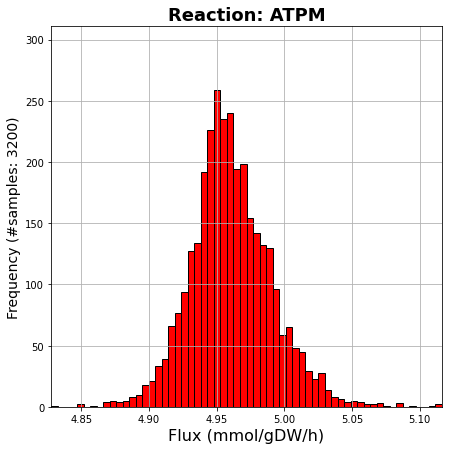

In [ ]:
# plot the histogram for a reaction (n) of the E. coli metabolic network

reactions = model.reactions
plot_histogram(
        steady_states[80],  # here we set which reaction's flux we need to get 
        reactions[80],      # here we provide the name of the reaction
        n_bins = 60,
)

## The GeomScale Org. project

[Geomscale Org](https://geomscale.github.io/) is a research and development project that delivers open source code for state-of-the-art algorithms at the intersection of data science, optimization, geometric, and statistical computing. 

`dingo` is based on the `volesti` package; an open source project, [C++ library](https://github.com/GeomScale/volume_approximation) for volume approximation and sampling of convex bodies.

GeomScale is part of [NumFOCUS](https://numfocus.org/) and a Google Summer of Code [(GSoC) organization](https://summerofcode.withgoogle.com/organizations/5553085268623360/). 



## notes..

In [ ]:
# Here is a piece of code to allow to the notebook see my drive
# from google.colab import drive
# drive.mount('/content/drive')

to add an image: 

https://drive.google.com/uc?id=